In [ ]:
!unzip '/content/drive/MyDrive/Tp3/vache_elephant.zip'

Archive:  /content/drive/MyDrive/Tp3/vache_elephant.zip
 extracting: vache_elephant/entrainement/elephant/e032b10b2df21c22d2524518b7444f92e37fe5d404b0144390f8c07aa5ecb6_640.jpg  
 extracting: vache_elephant/entrainement/elephant/e130b80b2ef11c22d2524518b7444f92e37fe5d404b0144390f8c07aa4e5b0_640.jpg  
 extracting: vache_elephant/entrainement/elephant/e131b0072ee90021d85a5854ee454296eb70e3c818b413449df1c27ba6ee_640.jpg  
 extracting: vache_elephant/entrainement/elephant/e132b10a2bf51c22d2524518b7444f92e37fe5d404b0144390f8c07aa4e5b0_640.jpg  
 extracting: vache_elephant/entrainement/elephant/e133b10d2bf21c22d2524518b7444f92e37fe5d404b0144390f8c07aa4e5b0_640.jpg  
 extracting: vache_elephant/entrainement/elephant/e133b5062cf71c22d2524518b7444f92e37fe5d404b0144390f8c07aa4e5b0_640.jpg  
 extracting: vache_elephant/entrainement/elephant/e135b0062efc1c22d2524518b7444f92e37fe5d404b0144390f8c07aa4e5b0_640.jpg  
 extracting: vache_elephant/entrainement/elephant/e135b10f21f61c22d2524518b7444f92e37

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 120, 120, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                             

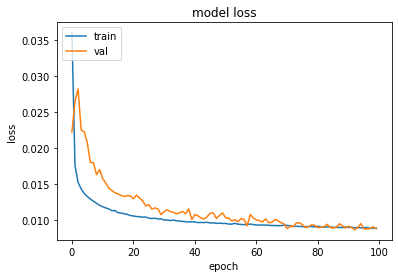

In [ ]:

# ===========================================================================
# TP3 : INF7370 - Hiver 2022
#
# Mohamad Hawchar : HAWM20039905
# Nassir Ade-Dayo Adekoudjo: ADEA04089904

#===========================================================================

# #===========================================================================
# Ce modèle est un Autoencodeur Convolutif entrainé sur l'ensemble de données MNIST afin d'encoder et reconstruire les images des chiffres 2 et 7.
# MNIST est une base de données contenant des chiffres entre 0 et 9 Ècrits à la main en noire et blanc de taille 28x28 pixels
# Pour des fins d'illustration, nous avons pris seulement deux chiffres 2 et 7
#
# Données:
# ------------------------------------------------
# entrainement : classe '2': 1 000 images | classe '7': images 1 000 images
# validation   : classe '2':   200 images | classe '7': images   200 images
# test         : classe '2':   200 images | classe '7': images   200 images
# ------------------------------------------------

# >>> Ce code fonctionne sur MNIST.
# >>> Vous devez donc intervenir sur ce code afin de l'adapter aux données du TP3.
# >>> À cette fin repérer les section QUESTION et insérer votre code et modification à ces endroits

# ==========================================
# ======CHARGEMENT DES LIBRAIRIES===========
# ==========================================

# La libraire responsable du chargement des données dans la mémoire
from keras.preprocessing.image import ImageDataGenerator

# Le Model à compiler
from keras.models import Model

# Le type d'optimisateur utilisé dans notre modèle (RMSprop, adam, sgd, adaboost ...)
# L'optimisateur ajuste les poids de notre modèle par descente du gradient
# Chaque optimisateur a ses propres paramètres
# Note: Il faut tester plusieurs et ajuster les paramètres afin d'avoir les meilleurs résultats

from tensorflow.keras.optimizers import Adam

# Les types des couches utlilisées dans notre modèle
from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization, UpSampling2D, Activation, Dropout, Flatten, LeakyReLU, Dense
from sklearn.preprocessing import StandardScaler
# Des outils pour suivre et gérer l'entrainement de notre modèle
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
from keras.regularizers import l1
# Configuration du GPU
import tensorflow as tf

# Affichage des graphes
import matplotlib.pyplot as plt

from keras import backend as K
import time

# ==========================================
# ===============GPU SETUP==================
# ==========================================

# Configuration des GPUs et CPUs
config = tf.compat.v1.ConfigProto(device_count={'GPU': 2, 'CPU': 4})
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess);

# ==========================================
# ================VARIABLES=================
# ==========================================

# ******************************************************
#                       QUESTION DU TP
# ******************************************************
# 1) Ajuster les variables suivantes selon votre problème:
# - mainDataPath
# - training_ds_size
# - validation_ds_size
# - image_scale
# - image_channels
# - images_color_mode
# - fit_batch_size
# - fit_epochs
# ******************************************************

# Le dossier principal qui contient les données
mainDataPath = "vache_elephant/"

# Le dossier contenant les images d'entrainement
trainPath = mainDataPath + "entrainement"

# Le dossier contenant les images de validation
validationPath = mainDataPath + "validation"

# Le nom du fichier du modèle à sauvegarder
model_path = "Model.hdf5"

# Le nombre d'images d'entrainement
training_ds_size = 2160  # total 2000 (1000 classe: 2 et 1000 classe: 7)
validation_ds_size = 240  # total 400 (200 classe: 2 et 200 classe: 7)


# Configuration des  images
image_scale = 120  # la taille des images
image_channels = 3  # le nombre de canaux de couleurs (1: pour les images noir et blanc; 3 pour les images en couleurs (rouge vert bleu) )
images_color_mode = "rgb"  # grayscale pour les image noir et blanc; rgb pour les images en couleurs
image_shape = (image_scale, image_scale,
               image_channels)  # la forme des images d'entrées, ce qui correspond à la couche d'entrée du réseau

# Configuration des paramètres d'entrainement
fit_batch_size = 32  # le nombre d'images entrainées ensemble: un batch
fit_epochs = 100  # Le nombre d'époques

# ==========================================
# ==================MODÈLE==================
# ==========================================

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#                       QUESTIONS DU TP
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Ajuster les deux fonctions:
# 2) encoder
# 3) decoder
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# Couche d'entrée:
# Cette couche prend comme paramètre la forme des images (image_shape)
input_layer = Input(shape=image_shape)


# Partie d'encodage (qui extrait les features des images et les encode)
def encoder(input):
    # 1- couche de convolution avec nombre de filtre  (exp 32)  avec la taille de la fenêtre de ballaiage exp : 3x3
    # 2- fonction d'activation exp: sigmoid, relu, tanh ...
    # 3- couche d'echantillonage (pooling) pour reduire la taille avec la taille de la fenêtre de ballaiage exp :2x2

    # **** On répète ces étapes tant que nécessaire ****
    
    #Pour notre modèle, nous utilisons une architecture semi-métrique d'encodeur-décodeur.
    # Nous avons expérimenté de nombreuses versions différentes de cette architecture et nous sommes arrivés à la conclusion que cette architecture est la meilleure
    #    pour capturer les caractéristiques des deux classes.
    # Explication des choix de l'architecture :
    # -Trois blocs de "convolution-sampling" : Nous avons essayé d'utiliser deux blocs au lieu de trois au début,
    #    le résultat obtenu n'était pas assez satisfaisant, nous avons donc augmenté à trois blocs
    #    dans le but de réduire beaucoup plus l'information spatiale (de 120x120 à 15x15) et de faire en sorte que l'algorithme se base et se concentre sur les caractéristiques 
    #    calculées pour représenter les classes.
    # -Poids dans l'ordre ([128,64,32] pour l'encodeur et [32,64,128] pour le décodeur : Nous avons expérimenté avec beaucoup de valeurs différentes,
    #    et nous avons conclu que la dimensionnalité totale et les paramètres à la fin de la phase d'encodage sont très importants pour la généralisation,
    #    c'est pourquoi le nombre de filtres diminue avec la dimensionnalité de l'image (pour la partie encodeur). Notre objectif est que le modèle ne garde que les quelques
    #    caractéristiques qui représentent les classes dans la couche d'intégration, ce choix rend l'image reconstruite plus floue car les paramètres de la couche d'intégration
    #    sont peu nombreux. Cependant, ce choix a permis d'augmenter le score de l'évaluation de l'encodeur.
    # -Dropout : Nous avons utilisé le dropout pour empêcher le modèle de mémoriser les données d'entraînement afin de lutter contre l'overfitting.
    # -Pas de normalisation par lot : l'utilisation de la normalisation par lot peut aider à accélérer le taux d'apprentissage, mais dans notre cas,
    #    nous n'avons pas vu la nécessité de l'utiliser car les pixels sont déjà normalisés entre les valeurs 0 et 255.
    # -Le leaky rely : les avantages du leaky relu sont qu'il augmente le temps d'apprentissage et qu'il résout le problème du dying relu, 
    #    il est également populaire pour les tâches d'autoencodage et de génération.
    #1
    x = Conv2D(32, (3, 3), padding='same')(input) 
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    # #2
    x = Conv2D(64, (3, 3), padding='same')(x) 
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    # #3
    x = Conv2D(128, (3, 3), padding='same')(x) 
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)

    encoded = MaxPooling2D((2, 2), padding='same')(x)


    # encoded : La sortie de l'encodeur consistue l'embedding (ou les descripteurs extraites par l'encodeur)
    return encoded


# Partie de décodage (qui reconstruit les images à partir de leur embedding ou la sortie de l'encodeur)
def decoder(encoded):
    # 1- couche de convolution avec nombre de filtre  (exp 32) (avec la taille de la fenêtre de ballaiage exp : 3x3)
    # 2- fonction d'activation exp: sigmoid, relu, tanh ...
    # 3- couche de suréchantillonnage pour augmenter la taille (avec la taille de la fenêtre de ballaiage exp :2x2)

    # l'enocdeur diminue la taille de l'image  et augmente le nombre de filtres de convolution progressivement
    # le decodeur augmente la taille de l'image et diminue le nombre de filtres de convolution progressivement

    # **** On répète ces étapes tant que nécessaire ****
    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    

    # la dernier couche doit avoir les mêmes dimensions de l'image d'entré (input)
    # (C'est très important, car nous somme entrain de reconstruire l'image d'entrée)
    x = Conv2D(image_channels, (3, 3), padding='same')(x)

    # la dernière couche doit passer par un sigmoide car les pixels des images sont
    # normalisées entre 0 et 1 et l'autoencodeur essaie de prédire chaque pixel par une valeur entre 0 et 1
    decoded = Activation('sigmoid')(x)
    return decoded


# Déclaration du modèle:
# La sortie de l'encodeur sert comme entrée à la partie decodeur
model = Model(input_layer, decoder(encoder(input_layer)))

# Affichage des paramétres du modèle
# Cette commande affiche un tableau avec les détails du modèle
# (nombre de couches et de paramétres ...)
model.summary()

# Compilation du modèle :
# loss: On définit la fonction de perte (généralement on utilise le MSE pour les autoencodeurs standards)
# optimizer: L'optimisateur utilisé avec ses paramétres (Exemple : optimizer=adam(learning_rate=0.001) )
# metrics: La valeur à afficher durant l'entrainement, metrics=['mse']
# On suit le loss (ou la difference) de l'autoencodeur entre les images d'entrée et les images de sortie
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# ==========================================
# ==========CHARGEMENT DES IMAGES===========
# ==========================================

# training_data_generator: charge les données d'entrainement en mémoire
# Les images sont normalisées (leurs pixels divisées par 255)
training_data_generator = ImageDataGenerator(rescale=1. / 255,
                                             validation_split=0.1)

# validation_data_generator: charge les données de validation en mémoire
# Les images sont normalisées (leurs pixels divisées par 255)
validation_data_generator = ImageDataGenerator(rescale=1. / 255)

# training_generator: indique la méthode de chargement des données d'entrainement
training_generator = training_data_generator.flow_from_directory(
    trainPath, # Place des images d'entrainement
    color_mode =images_color_mode, # couleur des images
    target_size=(image_scale, image_scale),# taille des images
    batch_size = training_ds_size, # nombre d'images total à entrainer
    subset='training',
    class_mode ="input") # Comme nous somme entrain de reconstruire les images, alors
                        # la classe de chacune des pixels de sorite est le pixel d'entrée elle même(Input pixel)

# validation_generatory: indique la méthode de chargement des données de validation
validation_generator = training_data_generator.flow_from_directory(
    trainPath, # Place des images d'entrainement
    color_mode =images_color_mode, # couleur des images
    target_size=(image_scale, image_scale),# taille des images
    batch_size = validation_ds_size, # nombre d'images total à valider
    subset='validation',
    class_mode ="input") # Comme nous somme entrain de reconstruire les images, alors
    
                        # la classe de chacune des pixels de sorite est le pixel d'entrée elle même(Input pixel)

# On charge les données d'entrainement en mémoire
(x_train, y_train) = training_generator.next()
# On charge les données de validation en mémoire
(x_val, y_val) = validation_generator.next()


# ==========================================
# ==============ENTRAINEMENT================
# ==========================================

# Savegarder le modèle avec le minimum loss sur les données de validation (monitor='val_loss')
# Note: on sauvegarde le modèle seulement quand le validation loss (la perte) diminue
# le loss ici est la difference entre les images originales (input) et les images reconstruites (output)
modelcheckpoint = ModelCheckpoint(filepath=model_path,
                                  monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# entrainement du modèle
# On remarque que pour la fonction "fit", la valeur de "x" (données d'entrainement) et celles de "y" (étiquettes) sont les mêmes
# C'est parce qu'on est entrain de reconstruire les pixels de l'image d'entrée
start = time.time()
autoencoder = model.fit(x_train, x_train,
                       epochs=fit_epochs, # nombre d'epochs
                       batch_size=fit_batch_size, # nombre d'images entrainées ensemble
                       verbose=1, # mets cette valeur à 0, si vous voulez ne pas afficher les détails d'entrainement
                       callbacks=[modelcheckpoint], # les fonctions à appeler à la fin de chaque epoch (dans ce cas modelcheckpoint: qui sauvegarde le modèle)
                       shuffle=False, # On ne boulverse pas les données
                       validation_data=(x_val, x_val)) # données de validation
execution_time = (time.time() - start)/60
# ==========================================
# ========AFFICHAGE DES RESULTATS===========
# ==========================================

# ***********************************************
#                    QUESTION
# ***********************************************
#
# 4) Afficher le temps d'execution
#
# ***********************************************
print("Total time: ", execution_time, " minutes")



# ***********************************************
#                    QUESTION
# ***********************************************
#
# 5) Afficher la courbe de  perte par époque (loss over epochs)
#
# ***********************************************
plt.plot(autoencoder.history['loss'])
plt.plot(autoencoder.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:

from tensorflow.keras import backend as K
import gc

K.clear_session()

gc.collect()


4341

Found 400 images belonging to 2 classes.
(400, 120, 120, 3)


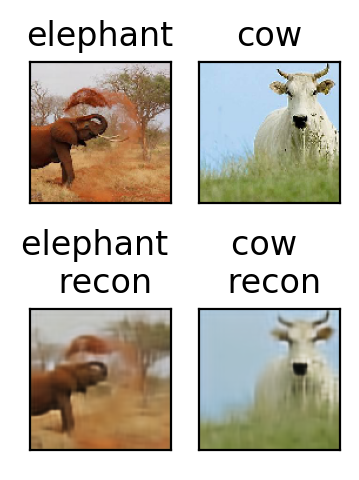

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 120, 120, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                             

In [ ]:
from numpy.core.fromnumeric import argmax
# **************************************************************************
# INF7370 Apprentissage automatique – Hiver 2022
# Travail pratique 3
# ===========================================================================

#===========================================================================
# Dans ce script, on évalue l'autoencodeur entrainé dans 1_Modele.py sur les données tests.
# On charge le modèle en mémoire puis on charge les images tests en mémoire
# 1) On évalue la qualité des images reconstruites par l'autoencodeur
# 2) On évalue avec une tache de classification la qualité de l'embedding
# 3) On visualise l'embedding en 2 dimensions avec un scatter plot


# ==========================================
# ======CHARGEMENT DES LIBRAIRIES===========
# ==========================================

# La libraire responsable du chargement des données dans la mémoire
from keras.preprocessing.image import ImageDataGenerator

# Affichage des graphes et des images
import matplotlib.pyplot as plt

# La librairie numpy
import numpy as np

# Configuration du GPU
import tensorflow as tf

# Utlilisé pour charger le modèle
from keras.models import load_model
from keras import Model

# Utilisé pour normaliser l'embedding
from sklearn.preprocessing import StandardScaler

from keras import backend as K
# La libraire responsable du chargement des données dans la mémoire
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization, UpSampling2D, Activation, Dropout, Flatten, LeakyReLU, Dense
from sklearn.preprocessing import StandardScaler


import time
# ==========================================
# ===============GPU SETUP==================
# ==========================================

# Configuration des GPUs et CPUs
config = tf.compat.v1.ConfigProto(device_count={'GPU': 2, 'CPU': 4})
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess);


# ==========================================
# ==================MODÈLE==================
# ==========================================

# Chargement du modéle (autoencodeur) sauvegardé dans la section 1 via 1_Modele.py
model_path = "Model.hdf5"
autoencoder = load_model(model_path)

# Configuration des  images
image_channels = 3  # le nombre de canaux de couleurs (1: pour les images noir et blanc; 3 pour les images en couleurs (rouge vert bleu) )
image_scale = 120
image_shape = (image_scale, image_scale,
               image_channels)  # la forme des images d'entrées, ce qui correspond à la couche d'entrée du réseau

# ==========================================
# ================VARIABLES=================
# ==========================================

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#                       QUESTIONS
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# 1) A ajuster les variables suivantes selon votre problème:
# - mainDataPath
# - number_images
# - number_images_class_x
# - image_scale
# - images_color_mode
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


# L'emplacement des images
mainDataPath = "vache_elephant/"

# On évalue le modèle sur les images tests
datapath = mainDataPath + "test"

# Le nombre des images de test à évaluer
number_images = 400 # 400 images
number_images_class_0 = 200 # 200 images pour la classe du chiffre 2
number_images_class_1 = 200 # 200 images pour la classe du chiffre 7

# Les étiquettes (classes) des images
labels = np.array([0] * number_images_class_0 +
                  [1] * number_images_class_1)

# La taille des images
image_scale = 120

# La couleur des images
images_color_mode = "rgb"  # grayscale ou rgb

# ==========================================
# =========CHARGEMENT DES IMAGES============
# ==========================================

# Chargement des images test
data_generator = ImageDataGenerator(rescale=1. / 255)

generator = data_generator.flow_from_directory(
    datapath, # Place des images d'entrainement
    color_mode=images_color_mode, # couleur des images
    target_size=(image_scale, image_scale),# taille des images
    batch_size= number_images, # nombre d'images total à charger en mémoire
    class_mode='binary',
    shuffle=False) # pas besoin de bouleverser les images

(x , y) = generator.next()

# ***********************************************
#                  QUESTIONS
# ***********************************************
#
# 2) Reconstruire les images tests en utilisant l'autoencodeur entrainé dans la première étape.
# Pour chacune des classes: Afficher une image originale ainsi que sa reconstruction.
# Afficher le titre de chaque classe au-dessus de l'image
# Note: Les images sont normalisées (entre 0 et 1), alors il faut les multiplier
# par 255 pour récupérer les couleurs des pixels
#
# ***********************************************
imgs = autoencoder.predict(x)
print(imgs.shape)

n = 2  # How many digits we will display
plt.figure(figsize=(2, 3), dpi = 200)
j = 0
for i in (3,340):
    # Display original
    ax = plt.subplot(2, n, j + 1)
    plt.imshow(x[i])
    ax.set_title( "cow" if y[i]//1 == 1 else "elephant")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, j + 1 + n)
    plt.imshow(imgs[i])
    ax.set_title(("cow" if y[i]//1 == 1 else "elephant") + " \n recon")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j = j+1
plt.show()

# ***********************************************
#                  QUESTIONS
# ***********************************************
#
# 3) Définire un modèle "encoder" qui est formé de la partie encodeur de l'autoencodeur
# Appliquer ce modèle sur les images afin de récupérer l'embedding
# Note: Il est "nécessaire" d'appliquer la fonction (flatten) sur l'embedding
# afin de réduire la représentation de chaque image en un seul vecteur
#
# ***********************************************

# Défintion du modèle
input_layer_index = 0 # l'indice de la première couche de l'encodeur (input)
output_layer_index = 12 # l'indice de la dernière couche (la sortie) de l'encodeur (dépend de votre architecture)
# note: Pour identifier l'indice de la dernière couche de la partie encodeur, vous pouvez utiliser la fonction "model.summary()"
# chaque ligne dans le tableau affiché par "model.summary" est compté comme une couche
encoder = Model(autoencoder.layers[input_layer_index].input, autoencoder.layers[output_layer_index].output)
encoder.summary()
imgs_encoder = encoder.predict(x)
embedding = Flatten(input_shape=image_shape)(imgs_encoder)

# ***********************************************
#                  QUESTIONS
# ***********************************************
#
# 4) Normaliser le flattened embedding (les vecteurs recupérés dans question 3)
# en utilisant le StandardScaler
# ***********************************************
scaler = StandardScaler()
scaler.fit(embedding)
normalized_embedding = scaler.transform(embedding)







In [ ]:
# # ***********************************************
# #                  QUESTIONS
# # ***********************************************
# #
# # 5) Appliquer un SVM Linéaire sur les images originales (avant l'encodage par le modèle)
# # Entrainer le modèle avec le cross-validation
# # Afficher la métrique suivante :
# #    - Accuracy
# # ***********************************************


from sklearn import datasets, svm, metrics
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import confusion_matrix

clf_original = svm.SVC(kernel='linear',
              C=1, 
              #probability=True
              )

x_flatten = Flatten(input_shape=image_shape)(x)

#normalization
scaler.fit(x_flatten)
x_flatten_normalized = scaler.fit_transform(x_flatten)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# cross validation helps in detecting overfitting. 
print(clf_original)
accuracy  = cross_val_score(clf_original, x_flatten_normalized,y, cv = cv, scoring='accuracy')
print(accuracy)
print(np.mean(accuracy))



SVC(C=1, kernel='linear')
[0.7   0.65  0.725 0.65  0.675 0.725 0.775 0.675 0.525 0.775]
0.6875000000000001


In [ ]:
from tensorflow.keras import backend as K
import gc

K.clear_session()

gc.collect()

793

In [ ]:

# ***********************************************
#                  QUESTIONS
# ***********************************************
#
# 6) Appliquer un SVC Linéaire sur le flattened embedding normalisé
# Entrainer le modèle avec le cross-validation
# Afficher la métrique suivante :
#    - Accuracy
# ***********************************************

from sklearn import datasets, svm, metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
clf_embedding = svm.SVC(kernel='linear',
              C=1, 
              )
print(clf_embedding)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
accuracy_embedding  = cross_val_score(clf_embedding, normalized_embedding,y, cv =cv, scoring='accuracy')
print(accuracy_embedding)
print(np.mean(accuracy_embedding))



SVC(C=1, kernel='linear')
[0.825 0.725 0.825 0.825 0.725 0.875 0.875 0.75  0.7   0.85 ]
0.7975


In [ ]:
clf_embedding.fit(normalized_embedding,y)


SVC(C=1, kernel='linear')

In [ ]:
def predict_generator(model, gen):
    # Predict latent-space map
    pred_maps = encoder.predict_generator(generator,steps = len(generator))
    print(pred_maps.shape)
    # Predict latent-space vector
    pred_enb = pred_maps.reshape(x.shape[0], -1)
    return pred_enb

# Predict latent-space vector
pred_enb = predict_generator(clf_embedding, generator)
pred_enb.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


(400, 15, 15, 128)


(400, 28800)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


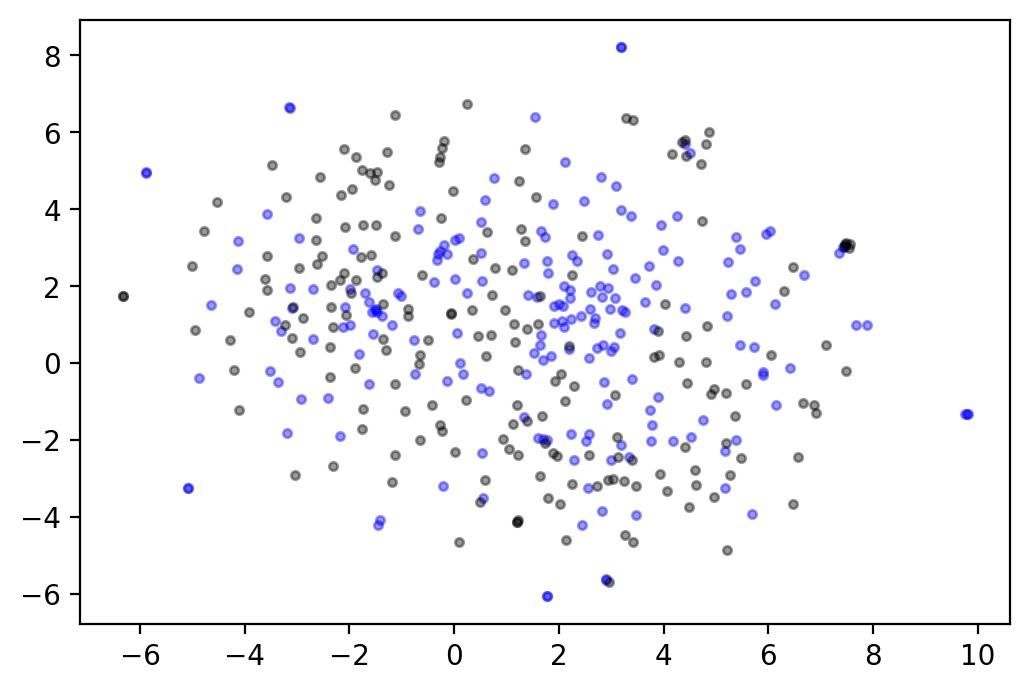

In [ ]:


# ***********************************************
#                  QUESTIONS
# ***********************************************
#
# 7) Appliquer TSNE sur le flattened embedding afin de réduire sa dimensionnalité en 2 dimensions
# Puis afficher les 2D features dans un scatter plot en utilisant 2 couleurs(une couleur par classe)
# ***********************************************
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

enb_reduce = TSNE(n_components=2).fit_transform(embedding)

plt.figure(dpi=200)
for i in range(400):

  if y[i]==1:
    plt.scatter(enb_reduce[i,0], enb_reduce[i,1], color = 'black' ,alpha=.4, s=3**2)
  else:
    plt.scatter(enb_reduce[i,0], enb_reduce[i,1], color = 'blue', alpha=.4, s=3**2)


plt.show()


La fidélité de la reconstruction
<br><br>
Dans les premières versions de notre modèle, la sortie de l'encodeur était plus grande en termes de dimensionnalité spatiale (largeur X hauteur), ce qui conduisait à une meilleure et moins bruyante reconstruction des images originales. Cependant, cela signifie que l'encodeur garde beaucoup d'informations sur la valeur initiale des pixels et pas les caractéristiques essentielles dont nous avons besoin pour différencier les vaches des éléphants, c'est pourquoi nous avons ajouté plus de blocs de convolution-déséchantillonnage à notre modèle, dans le but de faire en sorte que l'encodeur ne garde que les caractéristiques importantes.
<br>
<br>
La séparation des classes dans le nuage de points
<br>
<br>
Le nuage de points nous montre que l'intégration résultante après avoir passé les données de test n'est pas parfaitement séparée pour les deux classes que nous avons, ce qui est attendu puisque l'évaluation actuelle est de 79%, ce qui signifie qu'il y a plus de 40 mauvaises classifications pour chaque classe, et plus de 80 au total. De plus, on peut voir que les notes bleues qui représentent la classe des éléphants sont plus regroupées au centre et en haut à droite du graphique, alors que les notes noires qui représentent la classe des vaches sont plus regroupées à gauche et en bas du graphique.
<br><br>
Les résultats de classification du SVM (appliqué sur l'incorporation et sur les données de test originales).
<br><br>
application sur les données originales :
Puisque nous travaillons avec des images sans représentation carachtéristique, l'algorithme SVM va essayer de séparer les classes les unes des autres en dépendant uniquement des valeurs des 120*120*3 = 43200 pixels qui composent chaque image. Après l'application de la validation croisée, le modèle a réussi à atteindre une précision de 68,7% sur les images brutes.
<br><br>
Application sur l'embedding:
Ici, nous utilisons l'encodeur développé dans la tâche 1 pour obtenir une représentation caractéristique des images de test. Après l'application de la validation croisée, nous avons obtenu une précision moyenne de 79,75% en battant le SVM sur les données brutes de 11%, ce qui indique que notre modèle auto-encodeur a participé positivement à la tâche d'extraction de caractéristiques et de classification des deux animaux, les vaches et les éléphants.
<br><br>
Conclusion:
<br><br>

Problèmes rencontrés :
-Sur-ajustement : l'absence de méthodes de régularisation a fait que le modèle s'est sur-ajusté aux données, nous avons résolu ce problème en ajoutant une couche de dropout pour tous les blocs de convolution que nous avons.
-Modèle simple avec des images décodées presque parfaites : La simplicité de la première architecture que nous avons essayée a conduit à ce que la couche d'intégration ait une dimension spatiale élevée (hauteur X largeur), ce qui a conduit à ce que la partie décodeur ait beaucoup d'informations sur l'image originale, ce qui, à terme, a conduit à une reconstruction presque parfaite des images. Nous avons résolu ce problème en ajoutant plus de couches à nos parties encodeur et décodeur, ce qui nous a permis de réduire la dimensionnalité spatiale de (120 X 120) à (15 X15) et a conduit à une reconstruction floue des images, mais globalement à une meilleure représentation caractéristique des images.<br>
-Les valeurs du nombre de filtres pour les convolutions ont conduit à une mauvaise représentation : Si nous utilisions plus ou moins de filtres, les résultats étaient affectés négativement, dans notre dernière tentative, nous sommes arrivés à la conclusion d'augmenter le nombre de filtres à chaque fois que nous diminuons la taille de l'image, notre hypothèse est que nous n'avons pas besoin de beaucoup d'extraction de caractéristiques lorsque l'image était grande, mais nous devons augmenter le nombre de filtres tout en diminuant la taille pour essayer de condenser les caractéristiques petit à petit jusqu'à ce que nous atteignions un nombre suffisant et faible de paramètres à la fin de l'étape d'encodage.
<br><br>
Pour améliorer notre modèle : 
-nous pourrions essayer d'implémenter une couche dense à la fin de l'encodeur pour voir son effet sur l'apprentissage.
-nous expérimenterions avec des architectures et des tailles d'images originales plus complexes.
<br>
